In [27]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.neural_network import MLPRegressor
import joblib

In [28]:
def load_dataset(file_path):
    with open(file_path, "r") as f:
        data = json.load(f)
    texts, labels = [], []
    for record in data:
        text = record["document"]["text"]
        trait_dict = {t["name"]: t["strength"] for t in record["traits"]}
        # Ensure all Big Five traits present (fill with 0 if missing)
        all_traits = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism"]
        label = [trait_dict.get(trait, 0.0) for trait in all_traits]
        texts.append(text)
        labels.append(label)
    return texts, np.array(labels)

train_texts, train_labels = load_dataset("train_dataset.json")
val_texts, val_labels = load_dataset("validation_dataset.json")
test_texts, test_labels = load_dataset("test_dataset.json")

print(f"Loaded datasets: train={len(train_texts)}, val={len(val_texts)}, test={len(test_texts)}")

Loaded datasets: train=70, val=15, test=15


In [29]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

train_embeds = embedder.encode(train_texts, show_progress_bar=True)
val_embeds = embedder.encode(val_texts, show_progress_bar=True)
test_embeds = embedder.encode(test_texts, show_progress_bar=True)

Batches: 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


In [30]:
param_grid_rf = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

best_rf_params = None
best_rf_val_mse = float("inf")

for params in ParameterGrid(param_grid_rf):
    model = MultiOutputRegressor(RandomForestRegressor(random_state=42, **params))
    model.fit(train_embeds, train_labels)
    val_preds = model.predict(val_embeds)
    mse = mean_squared_error(val_labels, val_preds)
    print(f"RF Params: {params}, Val MSE: {mse:.4f}")
    if mse < best_rf_val_mse:
        best_rf_val_mse = mse
        best_rf_params = params

print("\n✅ Best RandomForest hyperparameters:", best_rf_params)
print(f"Validation MSE: {best_rf_val_mse:.4f}")

# Retrain on combined train+val
X_combined = np.vstack((train_embeds, val_embeds))
y_combined = np.vstack((train_labels, val_labels))
rf_model = MultiOutputRegressor(RandomForestRegressor(random_state=42, **best_rf_params))
rf_model.fit(X_combined, y_combined)
joblib.dump(rf_model, "rf_trait_regressor.pkl")
print("✅ RandomForest model saved.")

RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}, Val MSE: 0.0842
RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}, Val MSE: 0.0846
RF Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}, Val MSE: 0.0838
RF Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}, Val MSE: 0.0839
RF Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}, Val MSE: 0.0842
RF Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}, Val MSE: 0.0836
RF Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}, Val MSE: 0.0848
RF Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 300}, Val MSE: 0.0845
RF Params: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 500}, Val MSE: 0.0838
RF Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}, Val MSE: 0.0842
RF Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 

In [31]:
param_grid_mlp = {
    "hidden_layer_sizes": [(128,), (256,), (128, 64)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [1e-3, 1e-4]
}

best_mlp_params = None
best_mlp_val_mse = float("inf")

for params in ParameterGrid(param_grid_mlp):
    model = MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=300, **params))
    model.fit(train_embeds, train_labels)
    val_preds = model.predict(val_embeds)
    mse = mean_squared_error(val_labels, val_preds)
    print(f"MLP Params: {params}, Val MSE: {mse:.4f}")
    if mse < best_mlp_val_mse:
        best_mlp_val_mse = mse
        best_mlp_params = params

print("\n✅ Best MLP hyperparameters:", best_mlp_params)
print(f"Validation MSE: {best_mlp_val_mse:.4f}")

# Retrain MLP on combined train+val
mlp_model = MultiOutputRegressor(MLPRegressor(random_state=42, max_iter=300, **best_mlp_params))
mlp_model.fit(X_combined, y_combined)
joblib.dump(mlp_model, "mlp_trait_regressor.pkl")
print("✅ Neural MLP model saved.")

MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}, Val MSE: 0.0745
MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001}, Val MSE: 0.0650
MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.001}, Val MSE: 0.0821
MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.0001}, Val MSE: 0.0720
MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}, Val MSE: 0.0765


/Users/juliawang/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Params: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.0001}, Val MSE: 0.0681
MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}, Val MSE: 0.0743
MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001}, Val MSE: 0.0650
MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.001}, Val MSE: 0.0822
MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.0001}, Val MSE: 0.0719
MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}, Val MSE: 0.0763


/Users/juliawang/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.0001}, Val MSE: 0.0683
MLP Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}, Val MSE: 0.0747
MLP Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001}, Val MSE: 0.0657
MLP Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.001}, Val MSE: 0.0819
MLP Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.0001}, Val MSE: 0.0721
MLP Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}, Val MSE: 0.0757


/Users/juliawang/Library/Python/3.9/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLP Params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.0001}, Val MSE: 0.0675
MLP Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}, Val MSE: 0.0937
MLP Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.0001}, Val MSE: 0.0677
MLP Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.001}, Val MSE: 0.1080
MLP Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (256,), 'learning_rate_init': 0.0001}, Val MSE: 0.0814
MLP Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001}, Val MSE: 0.1022
MLP Params: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.0001}, Val MSE: 0.0739
MLP Params: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (128,), 'learning_ra

In [32]:
trait_names = ["Openness", "Conscientiousness", "Extraversion", "Agreeableness", "Neuroticism"]

def evaluate_model(model, name, test_embeds, test_labels):
    preds = model.predict(test_embeds)
    mse = mean_squared_error(test_labels, preds)
    r2 = r2_score(test_labels, preds)
    print(f"\n📊 {name} Test Performance:")
    print(f"Overall MSE: {mse:.4f}, R²: {r2:.4f}")
    results = {}
    for i, trait in enumerate(trait_names):
        trait_mse = mean_squared_error(test_labels[:, i], preds[:, i])
        trait_r2 = r2_score(test_labels[:, i], preds[:, i])
        print(f" - {trait:<15} MSE: {trait_mse:.4f} | R²: {trait_r2:.4f}")
        results[trait] = {"MSE": trait_mse, "R2": trait_r2}
    return preds, results

rf_preds, rf_metrics = evaluate_model(rf_model, "RandomForest", test_embeds, test_labels)
mlp_preds, mlp_metrics = evaluate_model(mlp_model, "Neural MLP", test_embeds, test_labels)


📊 RandomForest Test Performance:
Overall MSE: 0.0955, R²: -0.0047
 - Openness        MSE: 0.0758 | R²: 0.2126
 - Conscientiousness MSE: 0.0684 | R²: 0.0146
 - Extraversion    MSE: 0.1283 | R²: -0.0361
 - Agreeableness   MSE: 0.0751 | R²: -0.3748
 - Neuroticism     MSE: 0.1297 | R²: 0.1599

📊 Neural MLP Test Performance:
Overall MSE: 0.0852, R²: 0.1058
 - Openness        MSE: 0.0578 | R²: 0.3997
 - Conscientiousness MSE: 0.0439 | R²: 0.3671
 - Extraversion    MSE: 0.1224 | R²: 0.0120
 - Agreeableness   MSE: 0.0796 | R²: -0.4587
 - Neuroticism     MSE: 0.1221 | R²: 0.2091


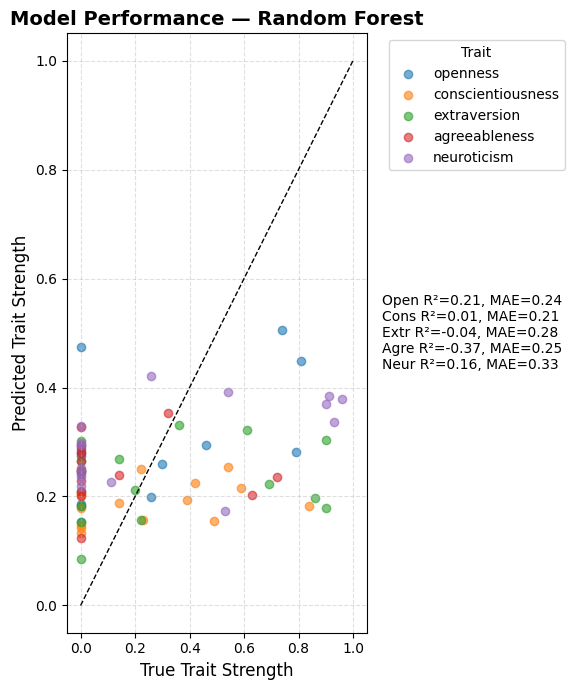

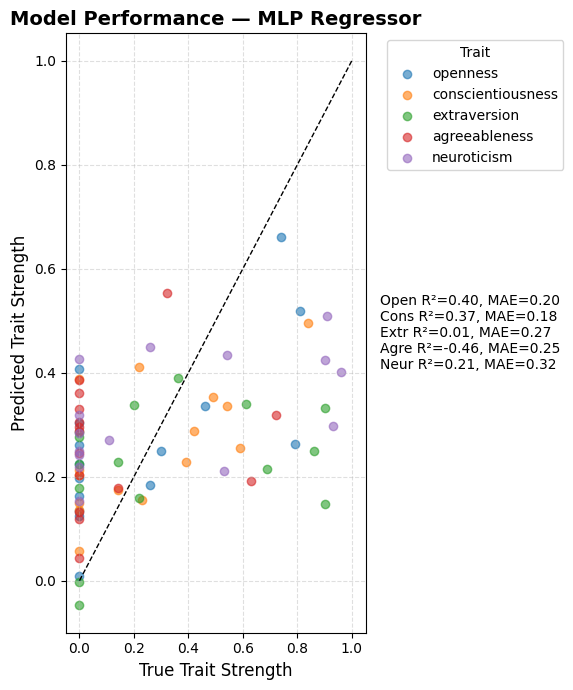

In [33]:

trait_names = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism"]
trait_colors = {
    "openness": "#1f77b4",          # blue
    "conscientiousness": "#ff7f0e", # orange
    "extraversion": "#2ca02c",      # green
    "agreeableness": "#d62728",     # red
    "neuroticism": "#9467bd"        # purple
}

def plot_model_performance(true_labels, pred_labels, model_name):
    """
    Plot all traits for one model in a single figure.
    Includes color-coded scatter points and annotated R² & MAE per trait.
    """
    plt.figure(figsize=(7, 7))
    metrics_texts = []

    for i, trait in enumerate(trait_names):
        color = trait_colors[trait]
        plt.scatter(
            true_labels[:, i],
            pred_labels[:, i],
            alpha=0.6,
            color=color,
            label=trait
        )
        # Compute metrics
        r2 = r2_score(true_labels[:, i], pred_labels[:, i])
        mae = mean_absolute_error(true_labels[:, i], pred_labels[:, i])
        metrics_texts.append(f"{trait[:4].title()} R²={r2:.2f}, MAE={mae:.2f}")

    # Reference line
    plt.plot([0, 1], [0, 1], 'k--', lw=1)
    plt.xlabel("True Trait Strength", fontsize=12)
    plt.ylabel("Predicted Trait Strength", fontsize=12)
    plt.title(f"Model Performance — {model_name}", fontsize=14, weight="bold")
    plt.grid(True, linestyle="--", alpha=0.4)
    
    # Legend & annotation box
    plt.legend(title="Trait", loc="upper left", bbox_to_anchor=(1.05, 1))
    text_box = "\n".join(metrics_texts)
    plt.gcf().text(1.05, 0.5, text_box, fontsize=10, va='center', transform=plt.gca().transAxes)
    
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# Plot both models’ results
plot_model_performance(test_labels, rf_preds, "Random Forest")
plot_model_performance(test_labels, mlp_preds, "MLP Regressor")

In [34]:
def save_results(preds, model_name):
    results = []
    for text, pred in zip(test_texts, preds):
        results.append({
            "document": text,
            "predicted_traits": {trait_names[j].lower(): float(pred[j]) for j in range(5)}
        })
    with open(f"{model_name.lower()}_predictions.json", "w") as f:
        json.dump(results, f, indent=2)
    print(f"✅ {model_name} predictions saved.")

save_results(rf_preds, "RandomForest")
save_results(mlp_preds, "MLP")

✅ RandomForest predictions saved.
✅ MLP predictions saved.
